In [2]:
import uproot3
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import glob
import os
from numpy import isnan
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from pylab import rcParams
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int32TensorType, BooleanTensorType

In [3]:
#open root tree with uproot
tree1 =  uproot3.open("NewTreesForGlobalTrackerSelection/MVA_JPsiMuMuGun_Pt0to20_Autumn18.root")["EC/mytree"]
tree2 =  uproot3.open("NewTreesForGlobalTrackerSelection/MVA_JPsiMuMuGun_Pt20to100_Autumn18.root")["EC/mytree"]
#tree3 =  uproot3.open("NewTreesForGlobalTrackerSelection/Charmonium_Run2018C_v1_10files.root")["muon/Events"]

#create list with variable names 
variables_gen = ['genpart_pt', 'genpart_eta', 'genpart_phi', 'genpart_Id', 'genpart_parentId', 'genpart_charge',\
                 'genpart_status']
variables_reco = ['mu_pt', 'mu_et', 'mu_phi', 'mu_dxy', 'mu_dz', 'Global_muon', 'Tracker_muon', 'Medium_muon', 'Tight_muon', 'Soft_muon', 'Loose_muon',\
                  'PF_muon', 'matching', 'norm_chi2', 'norm_chi2_inner', 'norm_chi2_bestTracker','local_chi2', 'kink', 'segment_comp', 'valid_hits',\
                  'valid_hits_inner', 'valid_hits_bestTracker', 'numb_MatchedStations', \
                  'valid_pixel', 'tracker_layers', 'validFraction', 'TrackerTrack_MuonSegment_Matched', \
                  'pixel_layers', 'track_highquality','SoftMVABs', 'SoftMVABs_score']
# variables_data = ['probe_pt', 'probe_eta', 'probe_phi', 'probe_dxy', 'probe_dz', 'probe_isGlobal', 'probe_isTracker', \
#                   'probe_isMedium', 'probe_isLoose', 'probe_isSoft', 'probe_isTight', 'probe_isLoose',\
#                   'probe_isPF', 'probe_trkChi2', 'probe_trkKink', 'probe_segmentCompatibility',
#                    'probe_muonHits', 'probe_pixelHits', 'probe_validFraction', \
#                   'probe_pixelLayers', 'probe_trackerLayers', 'probe_trackMuSegmentMatched', 'probe_matchedStations', 'probe_positionChi2', \
#                    'probe_isHighPurity']

#convert trees to arrays 
#Separately for gen and reco due to different length of arryas
array_gen1 = tree1.arrays(variables_gen)
array_reco1 = tree1.arrays(variables_reco)
array_gen2 = tree2.arrays(variables_gen)
array_reco2 = tree2.arrays(variables_reco)
#array_data = tree3.arrays(variables_data)

#Convert arrays to DataFrames and cncatenate for MC 
df_gen1 = pd.DataFrame(array_gen1)
df_reco1 = pd.DataFrame(array_reco1)

df_gen2 = pd.DataFrame(array_gen2)
df_reco2 = pd.DataFrame(array_reco2)

df_gen = pd.concat([df_gen1, df_gen2], axis=0)
df_reco = pd.concat([df_reco1, df_reco2], axis=0)
#df_probe = pd.DataFrame(array_data)

## Create array of arrays and concat for gen

In [4]:
#Concatenate array of arrays to create column of particles and not column of events
allgen_genpart_pt = df_gen[b'genpart_pt'].values
genpart_pt_concat = np.concatenate(allgen_genpart_pt)
allgen_genpart_eta = df_gen[b'genpart_eta'].values
genpart_eta_concat = np.concatenate(allgen_genpart_eta)
allgen_genpart_phi = df_gen[b'genpart_phi'].values
genpart_phi_concat = np.concatenate(allgen_genpart_phi)
allgen_genpart_Id = df_gen[b'genpart_Id'].values
genpart_Id_concat = np.concatenate(allgen_genpart_Id)
allgen_genpart_parentId = df_gen[b'genpart_parentId'].values
genpart_parentId_concat = np.concatenate(allgen_genpart_parentId)
allgen_genpart_charge = df_gen[b'genpart_charge'].values
genpart_charge_concat = np.concatenate(allgen_genpart_charge)
allgen_genpart_status = df_gen[b'genpart_status'].values
genpart_status_concat = np.concatenate(allgen_genpart_status)

#Make a new dataframe from the concat arrays
genpart_df_concatenate = pd.DataFrame(genpart_pt_concat, columns = ["genpart_pt"])
genpart_df_concatenate["genpart_eta"] =  genpart_eta_concat
genpart_df_concatenate["genpart_phi"] =  genpart_phi_concat
genpart_df_concatenate["genpart_Id"] =  genpart_Id_concat
genpart_df_concatenate["genpart_charge"] =  genpart_charge_concat
genpart_df_concatenate["genpart_status"] =  genpart_status_concat
genmuon_filter = abs(genpart_df_concatenate['genpart_Id'])==13
genpart_df_concatenate["genmuon_filter"]=genmuon_filter
#Make a concat df for the gen mons only
genmuons_dataframe = genpart_df_concatenate[abs(genpart_df_concatenate['genpart_Id'])==13]

## Create array of arrays and concat for reco

In [5]:
#kinematics and geometrics
recoMu_pt = df_reco[b'mu_pt'].values
recoMu_pt_concat = np.concatenate(recoMu_pt)
recoMu_eta = df_reco[b'mu_et'].values
recoMu_eta_concat = np.concatenate(recoMu_eta)
recoMu_phi = df_reco[b'mu_phi'].values
recoMu_phi_concat = np.concatenate(recoMu_phi)
recoMu_dxy = df_reco[b'mu_dxy'].values
recoMu_dxy_concat = np.concatenate(recoMu_dxy)
recoMu_dz = df_reco[b'mu_dz'].values
recoMu_dz_concat = np.concatenate(recoMu_dz)

#Muon IDs
recoMu_GlobalMu = df_reco[b'Global_muon'].values
recoMu_GlobalMu_concat = np.concatenate(recoMu_GlobalMu)
recoMu_MediumMu = df_reco[b'Medium_muon'].values
recoMu_MediumMu_concat = np.concatenate(recoMu_MediumMu)
recoMu_TightMu = df_reco[b'Tight_muon'].values
recoMu_TightMu_concat = np.concatenate(recoMu_TightMu)
recoMu_SoftMu = df_reco[b'Soft_muon'].values
recoMu_SoftMu_concat = np.concatenate(recoMu_SoftMu)
recoMu_PFMu = df_reco[b'PF_muon'].values
recoMu_PFMu_concat = np.concatenate(recoMu_PFMu)
recoMu_TrackerMu = df_reco[b'Tracker_muon'].values
recoMu_TrackerMu_concat = np.concatenate(recoMu_TrackerMu)
recoMu_LooseMu = df_reco[b'Loose_muon'].values
recoMu_LooseMu_concat = np.concatenate(recoMu_LooseMu)
recoMu_SoftMVABs = df_reco[b'SoftMVABs'].values
recoMu_SoftMVABs_concat = np.concatenate(recoMu_SoftMVABs)
recoMu_SoftMVABs_score = df_reco[b'SoftMVABs_score'].values
recoMu_SoftMVABs_score_concat = np.concatenate(recoMu_SoftMVABs_score)

#gen matching
recoMu_matching = df_reco[b'matching'].values
recoMu_matching_concat = np.concatenate(recoMu_matching)

#Quality cuts of the cut based ID
recoMu_normChi2 = df_reco[b'norm_chi2'].values
recoMu_normChi2_concat = np.concatenate(recoMu_normChi2)
recoMu_normChi2_inner = df_reco[b'norm_chi2_inner'].values
recoMu_normChi2_inner_concat = np.concatenate(recoMu_normChi2_inner)
recoMu_normChi2_bestTrack = df_reco[b'norm_chi2_bestTracker'].values
recoMu_normChi2_bestTrack_concat = np.concatenate(recoMu_normChi2_bestTrack)
recoMu_localChi2 = df_reco[b'local_chi2'].values
recoMu_localChi2_concat = np.concatenate(recoMu_localChi2)

recoMu_kink = df_reco[b'kink'].values
recoMu_kink_concat = np.concatenate(recoMu_kink)
recoMu_segmentCompat = df_reco[b'segment_comp'].values
recoMu_segmentCompat_concat = np.concatenate(recoMu_segmentCompat)
recoMu_validHits = df_reco[b'valid_hits'].values
recoMu_validHits_concat = np.concatenate(recoMu_validHits)
recoMu_validHits_inner = df_reco[b'valid_hits_inner'].values
recoMu_validHits_inner_concat = np.concatenate(recoMu_validHits_inner)
recoMu_validHits_bestTracker = df_reco[b'valid_hits_bestTracker'].values
recoMu_validHits_bestTracker_concat = np.concatenate(recoMu_validHits_bestTracker)
recoMu_numebrMatchedStations = df_reco[b'numb_MatchedStations'].values
recoMu_numebrMatchedStations_concat = np.concatenate(recoMu_numebrMatchedStations)
recoMu_validPixel = df_reco[b'valid_pixel'].values
recoMu_validPixel_concat = np.concatenate(recoMu_validPixel)
recoMu_trackerLayers = df_reco[b'tracker_layers'].values
recoMu_trackerLayers_concat = np.concatenate(recoMu_trackerLayers)
recoMu_validFraction = df_reco[b'validFraction'].values
recoMu_validFraction_concat = np.concatenate(recoMu_validFraction)
recoMu_TrackerTrack_MuonSegment_Matched = df_reco[b'TrackerTrack_MuonSegment_Matched'].values
recoMu_TrackerTrack_MuonSegment_Matched_concat = np.concatenate(recoMu_TrackerTrack_MuonSegment_Matched)
recoMu_pixelLayers = df_reco[b'pixel_layers'].values
recoMu_pixelLayers_concat = np.concatenate(recoMu_pixelLayers)
recoMu_TrackHighQual = df_reco[b'track_highquality'].values
recoMu_TrackHighQual_concat = np.concatenate(recoMu_TrackHighQual)

reco_df_concatenate = pd.DataFrame(recoMu_pt_concat, columns = ["mu_pt"])
reco_df_concatenate['pt'] =  np.where(reco_df_concatenate['mu_pt']<20,reco_df_concatenate['mu_pt'], 20)
reco_df_concatenate["eta"] = recoMu_eta_concat
reco_df_concatenate["mu_phi"] = recoMu_phi_concat
reco_df_concatenate["mu_dxy"] = recoMu_dxy_concat
reco_df_concatenate["mu_dz"] = recoMu_dz_concat
reco_df_concatenate["isPF"] = recoMu_PFMu_concat
reco_df_concatenate["isGlobal"] = recoMu_GlobalMu_concat
reco_df_concatenate["isSoft"] = recoMu_SoftMu_concat
reco_df_concatenate["isMedium"] = recoMu_MediumMu_concat
reco_df_concatenate["isTight"] = recoMu_TightMu_concat
reco_df_concatenate["isLoose"] = recoMu_LooseMu_concat
reco_df_concatenate["GenMatching"] = recoMu_matching_concat
reco_df_concatenate["norm_chi2"] = recoMu_normChi2_concat
reco_df_concatenate["normChi2_inner"] = recoMu_normChi2_inner_concat
reco_df_concatenate["local_chi2"] = recoMu_localChi2_concat
reco_df_concatenate["kink"] = recoMu_kink_concat
reco_df_concatenate["segment_comp"] = recoMu_segmentCompat_concat
reco_df_concatenate["n_Valid_hits"] = recoMu_validHits_concat
reco_df_concatenate["validHits_inner"] = recoMu_validHits_inner_concat
reco_df_concatenate["n_mu_segm"] = recoMu_numebrMatchedStations_concat
reco_df_concatenate["Valid_pixel"] = recoMu_validPixel_concat
reco_df_concatenate["tracker_layers"] = recoMu_trackerLayers_concat
reco_df_concatenate["validFraction"] =recoMu_validFraction_concat
reco_df_concatenate["TTrack_MuonSegm_matched"] = recoMu_TrackerTrack_MuonSegment_Matched_concat
reco_df_concatenate["pixel_layers"] = recoMu_pixelLayers_concat
reco_df_concatenate["TrackHighQual"] = recoMu_TrackHighQual_concat
reco_df_concatenate["SoftMVAIdBs"] = recoMu_SoftMVABs_concat
reco_df_concatenate["SoftMVAIdBs_score"] = recoMu_SoftMVABs_score_concat
reco_df_concatenate['SoftMVABs0p36'] = np.where(reco_df_concatenate['SoftMVAIdBs_score']>0.36, 1,0)

reco_df_concatenate = reco_df_concatenate.loc[((abs(reco_df_concatenate['eta'])<1.2) & (reco_df_concatenate['mu_pt']>3.5) & (reco_df_concatenate['mu_pt']<100))\
                                             |((abs(reco_df_concatenate['eta'])>1.2) & (reco_df_concatenate['mu_pt']>2) & (reco_df_concatenate['mu_pt']<100))] 

reco_df_concatenate = reco_df_concatenate[reco_df_concatenate['norm_chi2']<5000]
reco_df_concatenate = reco_df_concatenate[reco_df_concatenate['TrackHighQual']>0]

### Calculate efficiency in pt bins

In [6]:
# Soft Cut based ID MC
TPR_pt_CB = np.array([])
FPR_pt_CB = np.array([])
errors_TPR_CB = np.array([])
errors_FPR_CB = np.array([])
totSignal_CB = 0
totBkg_CB =0
totFP_CB=0
import math
for i in range (2, 30):
    locals()['reco_df_concatenate_{}_{}'.format(i,i+2)] = reco_df_concatenate[(reco_df_concatenate['mu_pt']<=i+1) &\
                                                      (reco_df_concatenate['mu_pt']>i) ]
    locals()['TP_CB_{}_{}'.format(i,i+2)] = locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][(abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])==6) & (locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['isSoft']==1)].shape[0]
    locals()['Signal_CB_{}_{}'.format(i,i+2)] = locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])==6].shape[0]
    locals()['FP_CB_{}_{}'.format(i,i+2)] =  locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][(abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])<3) & (locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['isSoft']==1)].shape[0]
    locals()['Bkg_CB_{}_{}'.format(i,i+2)] = locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])<3].shape[0]
    TPR_pt_CB = np.append(TPR_pt_CB, locals()['TP_CB_{}_{}'.format(i,i+2)]/locals()['Signal_CB_{}_{}'.format(i,i+2)])
    if (locals()['Bkg_CB_{}_{}'.format(i,i+2)]>0):
        FPR_pt_CB = np.append(FPR_pt_CB,locals()['FP_CB_{}_{}'.format(i,i+2)]/ locals()['Bkg_CB_{}_{}'.format(i,i+2)])
    else:
        FPR_pt_CB = np.append(FPR_pt_CB,0)
    errors_TPR_CB = np.append(errors_TPR_CB, (math.sqrt((locals()['TP_CB_{}_{}'.format(i,i+2)]/locals()['Signal_CB_{}_{}'.format(i,i+2)])*(1-(locals()['TP_CB_{}_{}'.format(i,i+2)]/locals()['Signal_CB_{}_{}'.format(i,i+2)]))*(1/locals()['Signal_CB_{}_{}'.format(i,i+2)]))))
    if (locals()['Bkg_CB_{}_{}'.format(i,i+2)]>0):
        errors_FPR_CB = np.append(errors_FPR_CB, (math.sqrt((locals()['FP_CB_{}_{}'.format(i,i+2)]/locals()['Bkg_CB_{}_{}'.format(i,i+2)])*(1-(locals()['FP_CB_{}_{}'.format(i,i+2)]/locals()['Bkg_CB_{}_{}'.format(i,i+2)]))*(1/locals()['Bkg_CB_{}_{}'.format(i,i+2)]))))
    else:
        errors_FPR_CB = np.append(errors_FPR_CB,1)
    totSignal_CB = totSignal_CB+locals()['Signal_CB_{}_{}'.format(i,i+2)]
    totBkg_CB = totBkg_CB+locals()['Bkg_CB_{}_{}'.format(i,i+2)]
    totFP_CB = totFP_CB+locals()['FP_CB_{}_{}'.format(i,i+2)]

In [7]:
# Tight ID MC
TPR_pt_CBMedium = np.array([])
FPR_pt_CBMedium = np.array([])
errors_TPR_CBMedium = np.array([])
errors_FPR_CBMedium = np.array([])
totSignal_CBMedium = 0
totBkg_CBMedium =0
totFP_CBMedium=0
import math
for i in range (2, 30):
    locals()['reco_df_concatenate_{}_{}'.format(i,i+2)] = reco_df_concatenate[(reco_df_concatenate['mu_pt']<=i+1) &\
                                                      (reco_df_concatenate['mu_pt']>i) ]
    locals()['TP_CBMedium_{}_{}'.format(i,i+2)] = locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][(abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])==6) & (locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['isMedium']==1)].shape[0]
    locals()['Signal_CBMedium_{}_{}'.format(i,i+2)] = locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])==6].shape[0]
    locals()['FP_CBMedium_{}_{}'.format(i,i+2)] =  locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][(abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])<3) & (locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['isMedium']==1)].shape[0]
    locals()['Bkg_CBMedium_{}_{}'.format(i,i+2)] = locals()['reco_df_concatenate_{}_{}'.format(i,i+2)][abs(locals()['reco_df_concatenate_{}_{}'.format(i,i+2)]['GenMatching'])<3].shape[0]
    TPR_pt_CBMedium = np.append(TPR_pt_CBMedium, locals()['TP_CBMedium_{}_{}'.format(i,i+2)]/locals()['Signal_CBMedium_{}_{}'.format(i,i+2)])
    FPR_pt_CBMedium = np.append(FPR_pt_CBMedium,locals()['FP_CBMedium_{}_{}'.format(i,i+2)]/ locals()['Bkg_CBMedium_{}_{}'.format(i,i+2)])
    errors_TPR_CBMedium = np.append(errors_TPR_CBMedium, (math.sqrt((locals()['TP_CBMedium_{}_{}'.format(i,i+2)]/locals()['Signal_CBMedium_{}_{}'.format(i,i+2)])*(1-(locals()['TP_CBMedium_{}_{}'.format(i,i+2)]/locals()['Signal_CBMedium_{}_{}'.format(i,i+2)]))*(1/locals()['Signal_CBMedium_{}_{}'.format(i,i+2)]))))
    errors_FPR_CBMedium= np.append(errors_FPR_CBMedium, (math.sqrt((locals()['FP_CBMedium_{}_{}'.format(i,i+2)]/locals()['Bkg_CBMedium_{}_{}'.format(i,i+2)])*(1-(locals()['FP_CBMedium_{}_{}'.format(i,i+2)]/locals()['Bkg_CBMedium_{}_{}'.format(i,i+2)]))*(1/locals()['Bkg_CBMedium_{}_{}'.format(i,i+2)]))))
    totSignal_CBMedium = totSignal_CBMedium+locals()['Signal_CBMedium_{}_{}'.format(i,i+2)]
    totBkg_CBMedium = totBkg_CBMedium+locals()['Bkg_CBMedium_{}_{}'.format(i,i+2)]
    totFP_CBMedium = totFP_CBMedium+locals()['FP_CBMedium_{}_{}'.format(i,i+2)]

### Calculate efficiency in eta bins

In [8]:
eta_bins = ([-2.4,-2.2], [-2.2,-2.0], [-2.0,-1.8], [-1.8, -1.6], [-1.6,-1.4], \
           [-1.4,-1.2], [-1.2,-1.0], [-1,-0.8], [-0.8,-0.6], [-0.6,-0.4],\
            [-0.4,-0.2], [-0.2,0.0],\
           [0,0.2], [0.2,0.4], [0.4,0.6], [0.6, 0.8], [0.8, 1.0], [1.0,1.2],\
           [1.2, 1.4], [1.4,1.6], [1.6,1.8], [1.8,2.0], [2.0, 2.2], [2.2, 2.4])
binning = ([-2.3,-2.1,-1.9, -1.7, -1.5, -1.3,-1.1, -0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7,\
          0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1,2.3])
TPR_eta_CB = ([])
FPR_eta_CB = ([])
errors_TPR_eta_CB = ([])
errors_FPR_eta_CB = ([])

tot_obj =0 
#Soft cut based ID MC
for bin in eta_bins:
    locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])] = \
        reco_df_concatenate[(reco_df_concatenate['eta']<=bin[1]) & (reco_df_concatenate['eta']>bin[0])]
    locals()['Signal_bin_CB_{}_{}'.format(bin[0],bin[1])] =\
       locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])][abs(locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])]['GenMatching'])==6].shape[0]
    locals()['TP_bin_CB_{}_{}'.format(bin[0],bin[1])] =\
        locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])][(abs(locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])]['GenMatching'])==6) &\
                                                             (locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])]['isSoft']==1)].shape[0]
    locals()['Bkg_bin_CB_{}_{}'.format(bin[0],bin[1])] =\
       locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])][abs(locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])]['GenMatching'])<3].shape[0]
    locals()['FP_bin_CB_{}_{}'.format(bin[0],bin[1])] =\
        locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])][(abs(locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])]['GenMatching'])<3) &\
                                                             (locals()['df_in_eta_bin_CB_{}_{}'.format(bin[0],bin[1])]['isSoft']==1)].shape[0]
    TPR_eta_CB = np.append(TPR_eta_CB,locals()['TP_bin_CB_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_CB_{}_{}'.format(bin[0],bin[1])])
    FPR_eta_CB = np.append(FPR_eta_CB,locals()['FP_bin_CB_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_CB_{}_{}'.format(bin[0],bin[1])])
    tot_obj = tot_obj + (locals()['Signal_bin_CB_{}_{}'.format(bin[0],bin[1])]+locals()['Bkg_bin_CB_{}_{}'.format(bin[0],bin[1])])
    errors_TPR_eta_CB = np.append(errors_TPR_eta_CB, (math.sqrt((locals()['TP_bin_CB_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_CB_{}_{}'.format(bin[0],bin[1])])*(1-(locals()['TP_bin_CB_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_CB_{}_{}'.format(bin[0],bin[1])]))*(1/locals()['Signal_bin_CB_{}_{}'.format(bin[0],bin[1])]))))
    errors_FPR_eta_CB = np.append(errors_FPR_eta_CB, (math.sqrt((locals()['FP_bin_CB_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_CB_{}_{}'.format(bin[0],bin[1])])*(1-(locals()['FP_bin_CB_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_CB_{}_{}'.format(bin[0],bin[1])]))*(1/locals()['Bkg_bin_CB_{}_{}'.format(bin[0],bin[1])]))))


In [9]:
# Medium ID MC
TPR_eta_CBMedium = ([])
FPR_eta_CBMedium = ([])
errors_TPR_eta_CBMedium = ([])
errors_FPR_eta_CBMedium = ([])

tot_obj =0 
for bin in eta_bins:
    locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])] = \
        reco_df_concatenate[(reco_df_concatenate['eta']<=bin[1]) & (reco_df_concatenate['eta']>bin[0])]
    locals()['Signal_bin_CBMedium_{}_{}'.format(bin[0],bin[1])] =\
       locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])][abs(locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]['GenMatching'])==6].shape[0]
    locals()['TP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])] =\
        locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])][(abs(locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]['GenMatching'])==6) &\
                                                             (locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]['isMedium']==1)].shape[0]
    locals()['Bkg_bin_CBMedium_{}_{}'.format(bin[0],bin[1])] =\
       locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])][abs(locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]['GenMatching'])<3].shape[0]
    locals()['FP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])] =\
        locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])][(abs(locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]['GenMatching'])<3) &\
                                                             (locals()['df_in_eta_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]['isMedium']==1)].shape[0]
    TPR_eta_CBMedium = np.append(TPR_eta_CBMedium,locals()['TP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_CBMedium_{}_{}'.format(bin[0],bin[1])])
    FPR_eta_CBMedium = np.append(FPR_eta_CBMedium, locals()['FP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_CBMedium_{}_{}'.format(bin[0],bin[1])])
    #tot_obj = tot_obj + (locals()['Signal_bin_SoftMVABs_{}_{}'.format(bin[0],bin[1])]+locals()['Bkg_bin_SoftMVABs_{}_{}'.format(bin[0],bin[1])])
    errors_TPR_eta_CBMedium = np.append(errors_TPR_eta_CBMedium, (math.sqrt((locals()['TP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_CBMedium_{}_{}'.format(bin[0],bin[1])])*(1-(locals()['TP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]))*(1/locals()['Signal_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]))))
    errors_FPR_eta_CBMedium = np.append(errors_FPR_eta_CBMedium, (math.sqrt((locals()['FP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_CBMedium_{}_{}'.format(bin[0],bin[1])])*(1-(locals()['FP_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]))*(1/locals()['Bkg_bin_CBMedium_{}_{}'.format(bin[0],bin[1])]))))
#print(tot_obj)

### Calculate pt-eta weights tobe applied on bkg

[ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20.]
19


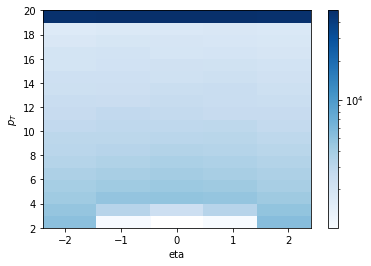

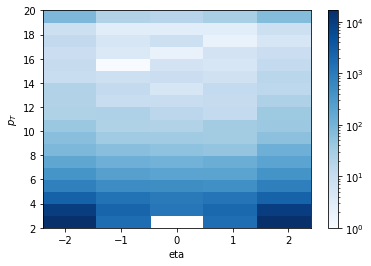

In [10]:
signal_filter = abs(reco_df_concatenate['GenMatching']) == 6
bkg_filter = abs(reco_df_concatenate['GenMatching']) < 3
reco_df_signal_preWeight = reco_df_concatenate[signal_filter]
reco_df_bkg_preWeight = reco_df_concatenate[bkg_filter]

# Variable pt binning
lowptBins = np.linspace(2,20,19)
med1ptBins = np.linspace(20,50, 7)
high1ptbins = np.linspace(50, 100, 2)
binning = [lowptBins]
binning = np.concatenate(binning)
binning = np.unique(binning, axis=0)
print(binning)

eta_bin_weight = 5
fig2d_sig, ax2d_sig = plt.subplots()
h2d_sig, xedges_sig, yedged_sig, image_sig = ax2d_sig.hist2d(reco_df_signal_preWeight['eta'], reco_df_signal_preWeight['pt'], cmin=1, bins=(eta_bin_weight,binning),cmap=plt.cm.Blues, norm=LogNorm())
plt.xlabel("eta")
plt.ylabel("$p_{T}$")
fig2d_sig.colorbar(image_sig, ax=ax2d_sig)
fig2d_bkg, ax2d_bkg = plt.subplots()
h2d_bkg, xedges_bkg, yedged_bkg, image_bkg = ax2d_bkg.hist2d(reco_df_bkg_preWeight['eta'], reco_df_bkg_preWeight['pt'], cmin=1, bins=(eta_bin_weight,binning),cmap=plt.cm.Blues, norm=LogNorm())
fig2d_bkg.colorbar(image_bkg, ax=ax2d_bkg)
plt.xlabel("eta")
plt.ylabel("$p_{T}$")
print(len(binning))
Weight_array = []
for i in range(eta_bin_weight):
    Weight_array.append([])
    for j in range(len(binning)-1):
        if h2d_bkg[i][j]!=0:
            Weight = h2d_sig[i][j]/h2d_bkg[i][j]  
        elif h2d_bkg[i][j]==0:
            Weight = 1
        Weight_array[i].append(Weight)
Weight_NParray = np.array(Weight_array )
where_are_NaNs = isnan(Weight_NParray)
Weight_NParray[where_are_NaNs] = 1

weight = lambda i, j : Weight_NParray[i,j]

reco_df_concatenate['isSignal'] = abs(reco_df_concatenate['GenMatching'])==6
reco_df_concatenate['eta_bin'] = pd.cut(reco_df_concatenate['eta'].values, xedges_bkg, labels=np.linspace(0, eta_bin_weight-1, num=eta_bin_weight, dtype=int))
reco_df_concatenate['pt_bin'] = pd.cut(reco_df_concatenate['pt'].values, yedged_bkg, labels=np.linspace(0, 17, num=18, dtype=int))
reco_df_concatenate['eta_binVals'] = pd.cut(reco_df_concatenate['eta'].values, xedges_bkg)
reco_df_concatenate['pt_binVals'] = pd.cut(reco_df_concatenate['pt'].values, yedged_bkg)

reco_df_concatenate.dropna(subset = ["eta_bin"], inplace=True)
reco_df_concatenate.dropna(subset = ["pt_bin"], inplace=True)
reco_df_concatenate['eta_bin'].astype("int")
reco_df_concatenate['pt_bin'].astype("int")
reco_df_concatenate['Weight'] = np.where(reco_df_concatenate['isSignal'] ==0, weight(reco_df_concatenate['eta_bin'], reco_df_concatenate['pt_bin']), 1)

## Split signal and bkg

In [11]:
signal_filter = abs(reco_df_concatenate['GenMatching']) == 6
bkg_filter = abs(reco_df_concatenate['GenMatching']) < 3
reco_df_signal = reco_df_concatenate[signal_filter]
reco_df_bkg = reco_df_concatenate[bkg_filter]

### Plot pt and eta with weights to make sure the weights work as expected

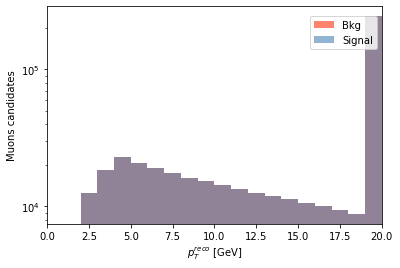

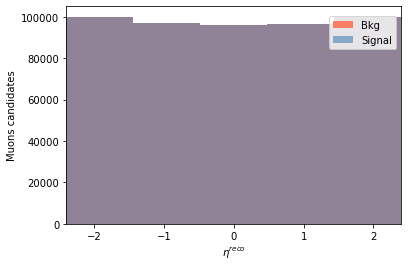

In [12]:
fig_reco_pt = plt.figure()
ax_reco_pt  = fig_reco_pt.add_subplot(111)
bins_reco_pt = np.linspace(0,20,21)
nBkg =plt.hist(reco_df_bkg["pt"].values,  bins =binning, weights=reco_df_bkg['Weight'].values , color='tomato', alpha=.8, label="Bkg")
nSig =plt.hist(reco_df_signal['pt'].values,  bins = binning, weights=reco_df_signal['Weight'].values,  color='steelblue', alpha=.6, label="Signal")
plt.xlabel('$p_{T}^{reco}$ [GeV]')
ax_reco_pt.set_xlim(0,20)
plt.yscale('log')
plt.ylabel('Muons candidates')
ax_reco_pt.legend(loc = 7,  bbox_to_anchor=(1, 0.88))

fig_reco_eta = plt.figure()
ax_reco_eta  = fig_reco_eta.add_subplot(111)
plt.hist(reco_df_bkg["eta"].values,  bins = eta_bin_weight, weights=reco_df_bkg['Weight'].values,  color='tomato', alpha=.8, label="Bkg")
plt.hist(reco_df_signal['eta'].values,  bins = eta_bin_weight, weights=reco_df_signal['Weight'].values,  color='steelblue', alpha=.6, label="Signal")
plt.xlabel('$\eta^{reco}$')
ax_reco_eta.set_xlim(-2.4,2.4)
plt.ylabel('Muons candidates')
ax_reco_eta.legend(loc = 7,  bbox_to_anchor=(1, 0.88))

In [13]:
print("The total signal is", reco_df_signal.shape[0], " and the tot Bkg is ", reco_df_bkg.shape[0])
print("---------------------------------------")
print("The signal passing CutBased SoftID is ", reco_df_signal[reco_df_signal['isSoft']==1].shape[0])
print("The bkg passign CutBase SoftId is ",reco_df_bkg[reco_df_bkg['isSoft']==1].shape[0] )
print("---------------------------------------")
CutBased_TPR = reco_df_signal[reco_df_signal['isSoft']==1].shape[0]/reco_df_signal.shape[0]
CutBased_FPR = reco_df_bkg[reco_df_bkg['isSoft']==1].shape[0]/reco_df_bkg.shape[0]
print("The TPR is ", CutBased_TPR )
print("The FPR is ", CutBased_FPR) 
print("---------------------------------------")
CutBasedMediumID_TPR = reco_df_signal[reco_df_signal['isMedium']==1].shape[0]/reco_df_signal.shape[0]
CutBasedMediumID_FPR = reco_df_bkg[reco_df_bkg['isMedium']==1].shape[0]/reco_df_bkg.shape[0]
print("The Medium ID TPR is ", CutBasedMediumID_TPR )
print("The Medium ID FPR is ", CutBasedMediumID_FPR) 
print("---------------------------------------")

The total signal is 489269  and the tot Bkg is  77211
---------------------------------------
The signal passing CutBased SoftID is  483308
The bkg passign CutBase SoftId is  46495
---------------------------------------
The TPR is  0.9878165181117136
The FPR is  0.6021810363808265
---------------------------------------
The Medium ID TPR is  0.9657305081662644
The Medium ID FPR is  0.3554674852028856
---------------------------------------


## Variables for training

In [14]:
vars_all = [ 'mu_pt','pt', 'eta',
            'norm_chi2', 'local_chi2', 'kink', 'segment_comp',
            'n_Valid_hits', 'n_mu_segm', 'Valid_pixel', 'tracker_layers',
            'validFraction', 'pixel_layers',
            'TTrack_MuonSegm_matched', 'TrackHighQual', 'SoftMVAIdBs', 'SoftMVAIdBs_score', 'Weight']

### Add final column with labels

In [15]:
reco_df_signal.loc[:,"label"] = 1
reco_df_bkg.loc[:,"label"] = 0

/Users/ioannapapavergou/opt/anaconda3/envs/NewERA/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ioannapapavergou/opt/anaconda3/envs/NewERA/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [16]:
X_trainbkg, X_testbkg, y_trainbkg, y_testbkg = train_test_split(reco_df_bkg[vars_all],reco_df_bkg['label'],\
                                                     test_size=0.4, random_state=4)

df_train_bkg=pd.concat([X_trainbkg,y_trainbkg], axis=1)
df_test_bkg=pd.concat([X_testbkg,y_testbkg], axis=1)
X_trainsig, X_testsig, y_trainsig, y_testsig = train_test_split(reco_df_signal[vars_all], reco_df_signal['label'],\
                                                    test_size=0.4, random_state=4)
df_test_signal=pd.concat([X_testsig,y_testsig], axis=1)
df_train_signal=pd.concat([X_trainsig,y_trainsig], axis=1)

df_train=pd.concat([df_train_bkg,df_train_signal],axis=0)
df_test=pd.concat([df_test_bkg,df_test_signal],axis=0)
df_test=df_test.dropna()
df_train=df_train.dropna()

df_test = df_test.sample(frac=1)
df_train = df_train.sample(frac=1)

In [17]:
df_test_signal = df_test['label'] ==1
df_train_signal = df_train['label'] ==1

df_test_bkg = df_test['label'] !=1
df_train_bkg = df_train['label'] !=1

In [18]:
vars_train = ['pt', 'eta', 'norm_chi2', 'local_chi2',
              'kink', 'segment_comp', 'n_Valid_hits',
              'n_mu_segm', 'Valid_pixel', 'tracker_layers',
              'validFraction',   'pixel_layers', 'TTrack_MuonSegm_matched']

In [19]:
df_test[vars_train]=df_test[vars_train].astype(np.float32)
df_train[vars_train]=df_train[vars_train].astype(np.float32)

In [20]:
model_GBC =  GradientBoostingClassifier(learning_rate=0.3, max_depth=7, min_samples_split=5,
                           n_estimators=59)
fit_model_GBC = model_GBC.fit(df_train[vars_train].values, df_train['label'].values,df_train['Weight'].values )

In [21]:
model_RF = RandomForestClassifier(max_depth=16, max_features=None, min_samples_leaf=3,
                       min_samples_split=6, n_estimators=250, random_state=0)
    
fit_model_RF = model_RF.fit(df_train[vars_train].values, df_train['label'].values, df_train["Weight"].values)


### Convert sklearn model to Onnx

In [22]:
initial_type = [('float_inputs', FloatTensorType([None, 13]))]
options = {id(fit_model_RF): {'zipmap': False}}
onx = convert_sklearn(fit_model_RF, initial_types=initial_type, options=options)
with open("SoftMVAID_Run3_RF.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [23]:
import onnxruntime as rt
sess = rt.InferenceSession("SoftMVAID_Run3_RF.onnx")
print("input name='{}' and shape={}".format(
    sess.get_inputs()[0].name, sess.get_inputs()[0].shape))
print("output name='{}' and shape={}".format(
    sess.get_outputs()[0].name, sess.get_outputs()[0].shape))

input name='float_inputs' and shape=[None, 13]
output name='label' and shape=[None]


In [51]:
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
pred_onx = sess.run([sess.get_outputs()[1].name], {input_name:df_train[vars_train].astype(np.float32).values})[0]

In [53]:
print("The scores of the models on the test sample are: ")
print("-------------------------------")
print("RF: " , fit_model_RF.score(df_test[vars_train].values, df_test['label'].values, df_test['Weight'].values))
print("GBC: ", fit_model_GBC.score(df_test[vars_train].values, df_test['label'].values, df_test['Weight'].values))
#print("MLP: ", fit_model_MLP.score(df_test[vars_train].values, df_test['label'].values, df_test['Weight'].values))

The scores of the models on the test sample are: 
-------------------------------
RF:  0.789383533356891
GBC:  0.8311868809433506


### Feature importnace 

In [30]:
from sklearn.inspection import permutation_importance
r = permutation_importance(fit_model_GBC, df_test[vars_train].values,df_test['label'].values , 
                           sample_weight=df_test['Weight'].values,
                            n_repeats=5,
                            random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{df_test.columns[i]:<13}       "
            f"{r.importances_mean[i]:.4f}"
            f" +/- {r.importances_std[i]:.4f}")


segment-Compat       0.2046 +/- 0.0072
ValidHitsinMuonChamb       0.0985 +/- 0.0065
TTrack_MuonSegm_matched       0.0981 +/- 0.0040
mu_pt               0.0287 +/- 0.0043
tracker-standalonePositionMatch       0.0208 +/- 0.0034
MuSegmentsInMuStations       0.0192 +/- 0.0009
normChi2            0.0117 +/- 0.0018
ValidTrackerHitsFraction       0.0091 +/- 0.0014
mu_eta              0.0065 +/- 0.0019
TrackerLayersHits       0.0062 +/- 0.0012
kink                0.0036 +/- 0.0028
PixelHits           0.0032 +/- 0.0007


In [227]:
from sklearn.inspection import permutation_importance
#df_test.drop(['PixelLayers', 'PixelHits', 'kink','TrackHighQual'], axis='columns', inplace=True)
r_RF = permutation_importance(fit_model_RF, df_test[vars_train].values, df_test['label'].values , 
                              sample_weight=df_test['Weight'].values,
                              n_repeats=5, random_state=0)
for i in r_RF.importances_mean.argsort()[::-1]:
    #if r_RF.importances_mean[i] - 2 * r_RF.importances_std[i] > 0:
    print(f"{df_test[vars_train].columns[i]:<13}       "
            f"{r_RF.importances_mean[i]:.4f}"
            f" +/- {r_RF.importances_std[i]:.4f}")


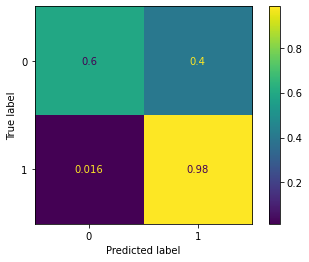

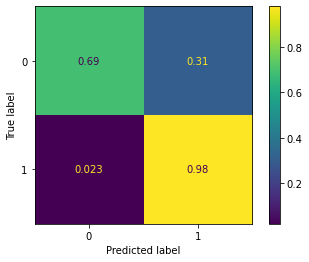

In [24]:
conf_matrix_RF = plot_confusion_matrix(fit_model_RF, df_test[vars_train], df_test['label'].values, sample_weight=df_test['Weight'].values, normalize='true')
plt.savefig("confussionMatrx_RF_pt3.pdf")

conf_matrix_GBC = plot_confusion_matrix(fit_model_GBC,df_test[vars_train], df_test['label'].values, sample_weight=df_test['Weight'].values, normalize='true')
plt.savefig("confussionMatrx_GBC_pt3.pdf")


### Compare train and test

[6.2070955  5.4465324  5.46654722 3.62643487 2.94718198 2.72201528
 2.57065321 2.37425781 1.90140773 1.62495305 1.21339835 0.99948998
 0.84187329 0.69426401 0.64297603 0.65798715 0.62171029 0.67925289
 0.69051123 0.63547048 0.68550752 0.61420473 0.51162879 0.51538157
 0.42406396 0.42781674 0.45408619 0.32899357 0.36276858 0.32398987
 0.34525561 0.3252408  0.37527784 0.3352482  0.33274635 0.31648431
 0.26644727 0.24768338 0.28896394 0.30397505 0.34025191 0.40655099
 0.47535193 0.53414546 0.66674363 0.92318349 1.21214743 0.99573721
 1.03451592 1.01199925] [2.49140432 2.33378071 2.33806485 1.90432006 1.71673585 1.64985311
 1.60332567 1.54086268 1.37891542 1.27473646 1.10154362 0.99974496
 0.91753653 0.83322506 0.80185786 0.81116407 0.78848608 0.824168
 0.83097005 0.79716402 0.82795382 0.78371215 0.71528232 0.71790081
 0.65120194 0.65407701 0.67385918 0.57357961 0.60230273 0.56920108
 0.58758456 0.57029887 0.61259925 0.57900622 0.57684171 0.56256938
 0.5161853  0.49767798 0.53755366 0.5513

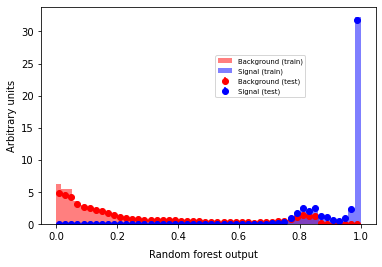

In [25]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, xlabel, bins=50):
    decisions = [] # list to hold decisions of classifier
    ratio = []
    bin_center = ([])
    for X,y in ((X_train, y_train), (X_test, y_test)): # train and test
        if hasattr(clf, "predict_proba"): # if predict_proba function exists
            d1 = clf.predict_proba(X[y==0])[:, 1] # background
            d2 = clf.predict_proba(X[y==1])[:, 1] # signal
        else: # predict_proba function doesn't exist
            X_tensor = torch.as_tensor(X, dtype=torch.float) # make tensor from X_test_scaled
            y_tensor = torch.as_tensor(y, dtype=torch.long) # make tensor from y_test
            X_var, y_var = Variable(X_tensor), Variable(y_tensor) # make variables from tensors
            d1 = clf(X_var[y_var<0.5])[1][:, 1].cpu().detach().numpy() # background
            d2 = clf(X_var[y_var>0.5])[1][:, 1].cpu().detach().numpy() # signal
        decisions += [d1, d2] # add to list of classifier decision
        
    highest_decision = max(np.max(d) for d in decisions) # get maximum score
    bin_edges = [] # list to hold bin edges
    bin_edge = 0 # start counter for bin_edges
    while bin_edge < highest_decision: # up to highest score
        bin_edge += 0.05 # increment
        bin_edges.append(bin_edge)
    fig, axis1 = plt.subplots()
    (n0, _, _) = axis1.hist(decisions[0], # background in train set
                 bins=bins, # lower and upper range of the bins
                 density=True, # area under the histogram will sum to 1
                 histtype='stepfilled', # lineplot that's filled
                 color='red', label='Background (train)', # Background (train)
                 alpha=0.5 ) # half transparency
    (n1, _, _)=axis1.hist(decisions[1], # background in train set
             bins=bins, # lower and upper range of the bins
             density=True, # area under the histogram will sum to 1
             histtype='stepfilled', # lineplot that's filled
             color='blue', label='Signal (train)', # Signal (train)
            alpha=0.5 ) # half transparency
    hist_background, bin_edges = np.histogram(decisions[2], # background test
                                              bins=bins, # number of bins in function definition
                                              density=True ) # area under the histogram will sum to 1
    scale = len(decisions[2]) / sum(hist_background) # between raw and normalised
    err_background = np.sqrt(hist_background * scale) / scale # error on test background

    width = 0.1 # histogram bin width
    center = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin centres
    
    axis1.errorbar(x=center, y=hist_background, yerr=err_background, fmt='o', # circles
                 c='red', label='Background (test)' ) # Background (test)
    
    hist_signal, bin_edges = np.histogram(decisions[3], # siganl test
                                          bins=bins, # number of bins in function definition
                                          density=True ) # area under the histogram will sum to 1
    scale = len(decisions[3]) / sum(hist_signal) # between raw and normalised
    err_signal = np.sqrt(hist_signal * scale) / scale # error on test background
    
    axis1.errorbar(x=center, y=hist_signal, yerr=err_signal, fmt='o', # circles
                c='blue', label='Signal (test)' ) # Signal (test)
    axis1.legend(loc = 7,  bbox_to_anchor=(0.8, 0.68), fontsize ='x-small')
    axis1.set_ylabel("Arbitrary units")
    for i in range(bin_edges.shape[0]):
        if i<bins: 
            bin_center = np.append(bin_center, (bin_edges[i]+bin_edges[i+1])/2)
    print(n0, np.sqrt(n0))
    fig.text(0.5, 0.008, xlabel, ha='center')
    fig.savefig("overtraining.pdf")
    

compare_train_test(fit_model_RF, df_train[vars_train], df_train['label'].values,df_test[vars_train], df_test['label'].values, 'Random forest output')


In [26]:
probs_test_RF        = fit_model_RF.predict_proba(df_test[vars_train])#predict probability over test sample
pred_y_test_RF  = fit_model_RF.predict(df_test[vars_train])
AUC_test_RF          = roc_auc_score(df_test['label'].values, probs_test_RF[:,1], sample_weight=df_test['Weight'].values)
print("Test Area under Curve RF= {0}".format(AUC_test_RF))
probs_test_GBC        = fit_model_GBC.predict_proba(df_test[vars_train])#predict probability over test sample
pred_y_test_GBC  = fit_model_GBC.predict(df_test[vars_train])
AUC_test_GBC         = roc_auc_score(df_test['label'].values, probs_test_GBC[:,1], sample_weight=df_test['Weight'].values)
print("Test Area under Curve GBC= {0}".format(AUC_test_GBC))

Test Area under Curve RF= 0.8648009290776058
Test Area under Curve GBC= 0.8789323608029667


### ROC curves

GBC accu score:  0.8311821193502745  RF accur score:  0.7874578852686483
Optimal threshold: 0.754801270535692


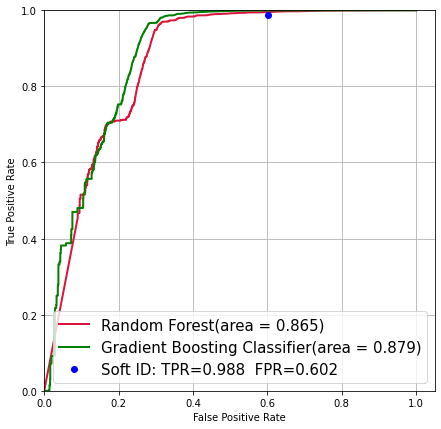

In [27]:
score_GBC=fit_model_GBC.score(df_test[vars_train], df_test['label'],df_test['Weight'].values)
score_RF=fit_model_RF.score(df_test[vars_train], df_test['label'], df_test['Weight'].values)
print("GBC accu score: ", score_GBC, " RF accur score: ", score_RF)
fpr_RF, tpr_RF, thresholds_test_RF      = roc_curve(df_test['label'], probs_test_RF[:,1], sample_weight=df_test['Weight'].values) #extract true positive rate and false positive rate
fpr_GBC, tpr_GBC, thresholds_test_GBC   = roc_curve(df_test['label'], probs_test_GBC[:,1], sample_weight=df_test['Weight'].values)

optimal_thres = thresholds_test_RF[np.argmax(tpr_RF - fpr_RF)]
print('Optimal threshold:', optimal_thres)
ROC = plt.figure(figsize=(7,7))
ax_ROC  = ROC.add_subplot(111)
plt.rcParams.update({'font.size': 15}) #Larger font size

plt.plot(fpr_RF,  tpr_RF, color='crimson', lw=2, label='Random Forest(area = {0:.3f})'.format(AUC_test_RF))
plt.plot(fpr_GBC, tpr_GBC, color='green', lw=2, label='Gradient Boosting Classifier(area = {0:.3f})'.format(AUC_test_GBC))

plt.xlim([0.0, 1.05])
plt.plot(CutBased_FPR, CutBased_TPR,'bo',label='Soft ID: TPR={0:.3f} '.format(CutBased_TPR)+' FPR={0:.3f}'.format(CutBased_FPR))
ax_ROC.set_ylim(0, 1)

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig('./ROCcurve_TrackHighQual_ptmin20.pdf')

In [28]:
threshold_array = np.array([])
tpr_array = np.array([])
fpr_array = np.array([])
for i in range(1,fpr_RF.size):
    threshold_array = np.append(threshold_array, thresholds_test_RF[i])
    tpr_array = np.append(tpr_array,tpr_RF[i])
    fpr_array = np.append(fpr_array,fpr_RF[i])
for i in range(1,len(threshold_array)):
    if thresholds_test_RF[i]== optimal_thres:
        print("The optimal threshold is: ", thresholds_test_RF[i], tpr_RF[i], fpr_RF[i])
        optimal_thres = thresholds_test_RF[i]
        optimal_thres_FPR=fpr_RF[i]
        optimal_thres_TPR=tpr_RF[i]

The optimal threshold is:  0.754801270535692 0.961181964968218 0.3071449633525511


In [29]:
for i in range(1,fpr_RF.size):
    if (tpr_RF[i] > CutBased_TPR):
        print("The threshold for TPR of cut based SoftID: ", thresholds_test_RF[i], tpr_RF[i], fpr_RF[i])
        Thres_same_TPR = thresholds_test_RF[i]
        SameTPR_thres_FPR=fpr_RF[i]
        SameTPR_thres_TPR=tpr_RF[i]
        break
for i in range(1,fpr_RF.size):
    if (fpr_RF[i] > CutBased_FPR):
        print("The threshold for FPR of cut based SoftID: ", thresholds_test_RF[i], tpr_RF[i], fpr_RF[i])
        Thres_same_FPR = thresholds_test_RF[i]
        SameFPR_thres_FPR=fpr_RF[i]
        SameFPR_thres_TPR=tpr_RF[i]        
        break

The threshold for TPR of cut based SoftID:  0.4017838788560857 0.9878236965274797 0.44049749733429266
The threshold for FPR of cut based SoftID:  0.1497155545946544 0.9953910928526172 0.6100629492844453


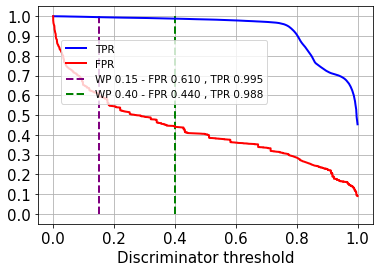

In [30]:
plotThreshold  = plt.figure()
ax_plotThreshold = plotThreshold.add_subplot(111)
plt.plot(threshold_array,tpr_array,color='blue', lw=2, label='TPR')
plt.plot(threshold_array,fpr_array,color='red', lw=2, label='FPR')
plt.grid(True)
plt.xlabel('Discriminator threshold')
plt.vlines(x=Thres_same_FPR, ymin=0, ymax=1, colors='purple', ls='--', lw=2, label='WP {0:.2f}'.format(Thres_same_FPR) +' - FPR {0:.3f}'.format(SameFPR_thres_FPR)+' , TPR {0:.3f}'.format(SameFPR_thres_TPR))
plt.vlines(x=Thres_same_TPR, ymin=0, ymax=1, colors='green',  ls='--', lw=2, label='WP {0:.2f}'.format(Thres_same_TPR) +' - FPR {0:.3f}'.format(SameTPR_thres_FPR)+' , TPR {0:.3f}'.format(SameTPR_thres_TPR))
ax_plotThreshold.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
plt.legend(loc=7, bbox_to_anchor=(0.7, 0.7), fontsize ='x-small')
plt.savefig('DiscriminatorThreshold_HighPurityTrack_ptmin20.pdf')

In [31]:
# Add columns with the predicted probability in the dataframe
df_test['predict_proba'] = probs_test_RF[:,1]
df_test['Probas'] = pred_y_test_RF

In [32]:
# Choose WP
ChooseThres =Thres_same_TPR
print(ChooseThres)

0.4017838788560857


## TPR and FPR in PT bins

In [33]:
import math

# Calculate Soft MVA ID efficiency in pt bins
After_Thres_tpr = np.array([])
After_Thres_fpr = np.array([])
errors_TPR = np.array([])
errors_FPR = np.array([])
bins = np.array([])
totSignal = 0

for i in range (2, 30):
    locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)] = df_test[(df_test['mu_pt']<=i+1) &\
                                                      (df_test['mu_pt']>i)]
    locals()['TP_{}_{}'.format(i,i+2)] = locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)][(locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)]['label']==1) & (locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)]['predict_proba']>ChooseThres)].shape[0]
    locals()['Signal_{}_{}'.format(i,i+2)] = locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)][locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)]['label']==1].shape[0]
    locals()['FP_{}_{}'.format(i,i+2)] =  locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)][(locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)]['label']!=1) & (locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)]['predict_proba']>ChooseThres)].shape[0]
    locals()['Bkg_{}_{}'.format(i,i+2)] = locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)][locals()['df_testPassingThreshold_{}_{}'.format(i,i+2)]['label']!=1].shape[0]
    After_Thres_tpr = np.append(After_Thres_tpr, locals()['TP_{}_{}'.format(i,i+2)]/locals()['Signal_{}_{}'.format(i,i+2)])
    if (locals()['Bkg_{}_{}'.format(i,i+2)]>0):
        After_Thres_fpr = np.append(After_Thres_fpr,locals()['FP_{}_{}'.format(i,i+2)]/ locals()['Bkg_{}_{}'.format(i,i+2)])
    else:
        After_Thres_fpr = np.append(After_Thres_fpr,0)
 
    errors_TPR = np.append(errors_TPR, (math.sqrt((locals()['TP_{}_{}'.format(i,i+2)]/locals()['Signal_{}_{}'.format(i,i+2)])*(1-(locals()['TP_{}_{}'.format(i,i+2)]/locals()['Signal_{}_{}'.format(i,i+2)]))*(1/locals()['Signal_{}_{}'.format(i,i+2)]))))
    if (locals()['Bkg_{}_{}'.format(i,i+2)]>0):
        errors_FPR = np.append(errors_FPR, (math.sqrt((locals()['FP_{}_{}'.format(i,i+2)]/locals()['Bkg_{}_{}'.format(i,i+2)])*(1-(locals()['FP_{}_{}'.format(i,i+2)]/locals()['Bkg_{}_{}'.format(i,i+2)]))*(1/locals()['Bkg_{}_{}'.format(i,i+2)]))))
    else:
        errors_FPR = np.append(errors_FPR,1)
    bins=np.append(bins,i+1/2)
    totSignal = totSignal+locals()['Signal_{}_{}'.format(i,i+2)]


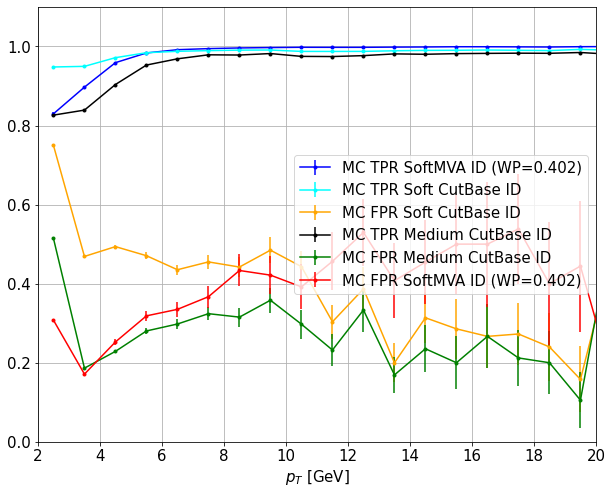

In [35]:
fig_FPR_pt = plt.figure(figsize=(10, 8))
ax_fig_FPR_pt = fig_FPR_pt.add_subplot(111)
ax_fig_FPR_pt.set_xticks([2,4,6,8,10,12,14,16,18,20])
plt.errorbar(bins, After_Thres_tpr,  yerr=errors_TPR, label='MC TPR SoftMVA ID (WP={0:.3f})'.format(ChooseThres), fmt='blue', marker='.')
plt.errorbar(bins, TPR_pt_CB, yerr=errors_TPR_CB, label='MC TPR Soft CutBase ID', fmt='cyan', marker='.')
plt.errorbar(bins, FPR_pt_CB, yerr=errors_FPR_CB, label='MC FPR Soft CutBase ID', fmt='orange', marker='.')
plt.errorbar(bins, TPR_pt_CBMedium, yerr=errors_TPR_CBMedium, label='MC TPR Medium CutBase ID', fmt='black', marker='.')
plt.errorbar(bins, FPR_pt_CBMedium, yerr=errors_FPR_CBMedium, label='MC FPR Medium CutBase ID', fmt='green', marker='.')

plt.errorbar(bins, After_Thres_fpr,  yerr=errors_FPR, label='MC FPR SoftMVA ID (WP={0:.3f})'.format(ChooseThres), fmt='red', marker='.')

plt.xlim([2,20])
plt.ylim([0,1.1])
plt.xlabel('$p_{T}$ [GeV]')

plt.legend()
plt.grid(True)

fig_FPR_pt.savefig("Threshold_TPR_FPR_{0:.3f}".format(ChooseThres)+"_HighPurityTrack_MediumCBID.pdf")

In [36]:
eta_bins = ([-2.4,-2.2], [-2.2,-2.0], [-2.0,-1.8], [-1.8, -1.6], [-1.6,-1.4], \
          [-1.4,-1.2], [-1.2,-1.0], [-1,-0.8], [-0.8,-0.6], [-0.6,-0.4],\
           [-0.4,-0.2], [-0.2,0.0],\
          [0,0.2], [0.2,0.4], [0.4,0.6], [0.6, 0.8], [0.8, 1.0], [1.0,1.2],\
          [1.2, 1.4], [1.4,1.6], [1.6,1.8], [1.8,2.0], [2.0, 2.2], [2.2, 2.4])
binning = ([-2.3,-2.1,-1.9, -1.7, -1.5, -1.3,-1.1, -0.9, -0.7, -0.5, -0.3, -0.1, 0.1, 0.3, 0.5, 0.7,\
                      0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1,2.3])
TPR_eta = ([])
FPR_eta = ([])
errors_TPR_eta = ([])
errors_FPR_eta = ([])

TotObj =0 
print("The total number of test obj is", df_test.shape[0])
for bin in eta_bins:
    locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])] = \
        df_test[(df_test['eta']<=bin[1]) & (df_test['eta']>bin[0])]
    TotObj = TotObj+locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])].shape[0]
    locals()['Signal_bin_{}_{}'.format(bin[0],bin[1])] =\
       locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])][locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])]['label']==1].shape[0]
    locals()['TP_bin_{}_{}'.format(bin[0],bin[1])] =\
        locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])][(locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])]['label']==1) &\
                                                           (locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])]['predict_proba']>ChooseThres)].shape[0]
    locals()['Bkg_bin_{}_{}'.format(bin[0],bin[1])] =\
       locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])][locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])]['label']!=1].shape[0]
    locals()['FP_bin_{}_{}'.format(bin[0],bin[1])] =\
        locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])][(locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])]['label']!=1) &\
                                                             (locals()['df_in_eta_bin_{}_{}'.format(bin[0],bin[1])]['predict_proba']>ChooseThres) ].shape[0]
    TPR_eta = np.append(TPR_eta,locals()['TP_bin_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_{}_{}'.format(bin[0],bin[1])])
    FPR_eta = np.append(FPR_eta,locals()['FP_bin_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_{}_{}'.format(bin[0],bin[1])])
    errors_TPR_eta = np.append(errors_TPR_eta, (math.sqrt((locals()['TP_bin_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_{}_{}'.format(bin[0],bin[1])])*(1-(locals()['TP_bin_{}_{}'.format(bin[0],bin[1])]/locals()['Signal_bin_{}_{}'.format(bin[0],bin[1])]))*(1/locals()['Signal_bin_{}_{}'.format(bin[0],bin[1])]))))
    errors_FPR_eta = np.append(errors_FPR_eta, (math.sqrt((locals()['FP_bin_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_{}_{}'.format(bin[0],bin[1])])*(1-(locals()['FP_bin_{}_{}'.format(bin[0],bin[1])]/locals()['Bkg_bin_{}_{}'.format(bin[0],bin[1])]))*(1/locals()['Bkg_bin_{}_{}'.format(bin[0],bin[1])]))))
    
TotObj

The total number of test obj is 226593


226593

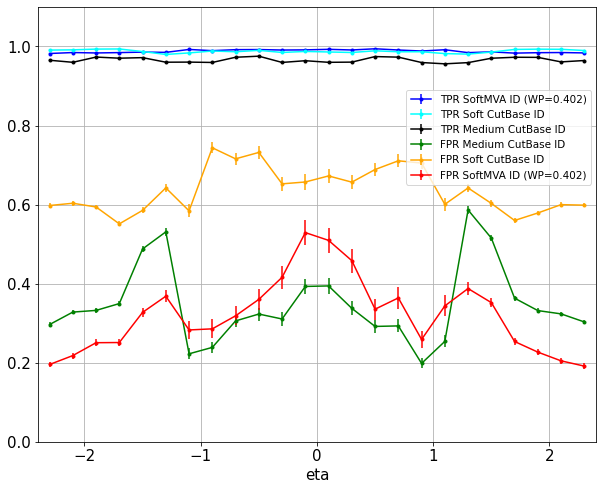

In [37]:
fig_FPR_eta = plt.figure(figsize=(10, 8))
ax_fig_FPR_eta = fig_FPR_eta.add_subplot(111)

plt.errorbar(binning, TPR_eta,  yerr=errors_TPR_eta, label='TPR SoftMVA ID (WP={0:.3f})'.format(ChooseThres), fmt='blue', marker='.')
plt.errorbar(binning, TPR_eta_CB, yerr=errors_TPR_eta_CB, label='TPR Soft CutBase ID', fmt='cyan', marker='.')
plt.errorbar(binning, TPR_eta_CBMedium, yerr=errors_TPR_eta_CBMedium, label='TPR Medium CutBase ID', fmt='black', marker='.')
plt.errorbar(binning, FPR_eta_CBMedium, yerr=errors_FPR_eta_CBMedium, label='FPR Medium CutBase ID', fmt='green', marker='.')
plt.errorbar(binning, FPR_eta_CB, yerr=errors_FPR_eta_CB, label='FPR Soft CutBase ID', fmt='orange', marker='.')
plt.errorbar(binning, FPR_eta,  yerr=errors_FPR_eta, label='FPR SoftMVA ID (WP={0:.3f})'.format(ChooseThres), fmt='red', marker='.')

plt.xlim([-2.4, 2.4])
plt.ylim([0,1.1])
plt.xlabel('eta')
plt.legend(loc = 7,  bbox_to_anchor=(1, 0.7), fontsize ='x-small')
plt.grid(True)

fig_FPR_eta.savefig("Threshold_eta_TPR_FPR_{0:.3f}".format(ChooseThres)+"_HighPurityTrack_MediumCBID.pdf")